In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import ParameterGrid
from models import MRIResNetClassifier
from multiprocessing import cpu_count

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

train_data_full = datasets.ImageFolder(root="cleaned/Training", transform=transform)
class_names = train_data_full.classes

train_size = int(0.8 * len(train_data_full))  # 80% za trening
val_size = len(train_data_full) - train_size  # 20% za validaciju

train_data, val_data = random_split(train_data_full, [train_size, val_size])
test_data = datasets.ImageFolder(root="cleaned/Testing", transform=transform)

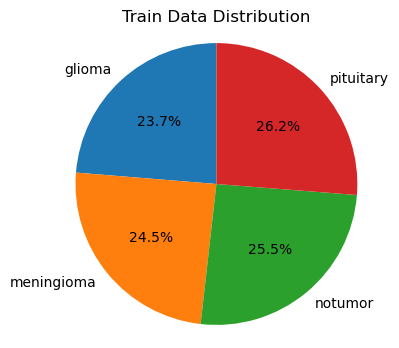

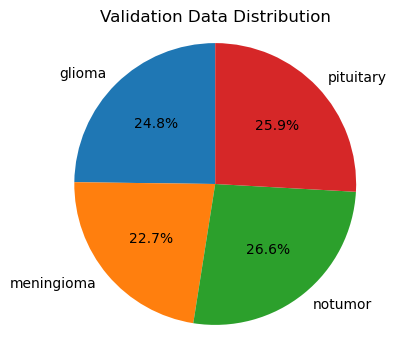

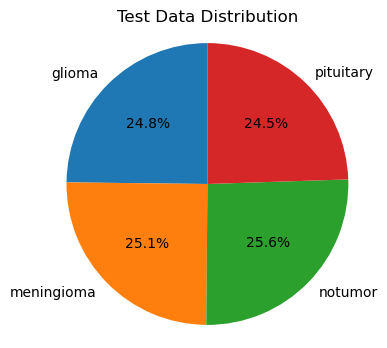

In [4]:
def plot_class_distribution(data, title):
    counts = Counter(data.targets if hasattr(data, 'targets') else [x[1] for x in data])
    labels = [class_names[i] for i in range(len(class_names))]
    plt.figure(figsize=(4, 4))
    plt.pie([counts[i] for i in range(len(class_names))], labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_class_distribution(train_data, "Train Data Distribution")
plot_class_distribution(val_data, "Validation Data Distribution")
plot_class_distribution(test_data, "Test Data Distribution")

In [5]:
train_targets = [train_data_full[i][1] for i in train_data.indices]
val_targets = [train_data_full[i][1] for i in val_data.indices]
test_targets = [label for _, label in test_data] 

def count_classes(targets, num_classes):
    counts = [0] * num_classes
    for target in targets:
        counts[target] += 1
    return counts

train_counts = count_classes(train_targets, len(class_names))
val_counts = count_classes(val_targets, len(class_names))
test_counts = count_classes(test_targets, len(class_names))


print("Train-Val-Test Split per Class:")
for i, class_name in enumerate(class_names):
    train_count = train_counts[i]
    val_count = val_counts[i]
    test_count = test_counts[i]
    total_count = train_count + val_count + test_count
    
    train_percentage = (train_count / total_count) * 100 if total_count > 0 else 0
    val_percentage = (val_count / total_count) * 100 if total_count > 0 else 0
    test_percentage = (test_count / total_count) * 100 if total_count > 0 else 0
    
    print(f"{class_name}: Train = {train_count} ({train_percentage:.2f}%), "
          f"Val = {val_count} ({val_percentage:.2f}%), "
          f"Test = {test_count} ({test_percentage:.2f}%)")

Train-Val-Test Split per Class:
glioma: Train = 1047 (64.63%), Val = 274 (16.91%), Test = 299 (18.46%)
meningioma: Train = 1082 (66.18%), Val = 251 (15.35%), Test = 302 (18.47%)
notumor: Train = 1128 (65.16%), Val = 294 (16.98%), Test = 309 (17.85%)
pituitary: Train = 1159 (66.61%), Val = 286 (16.44%), Test = 295 (16.95%)


In [6]:
num_workers = cpu_count() // 2

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=num_workers)

In [7]:
def train(model, epochs, train_loader, val_loader, optimizer, criterion, device):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        train_pred_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            train_pred_correct += (outputs.argmax(1) == labels).sum().item()
            total += len(labels)

        train_accuracy = train_pred_correct / total

        model.eval()
        total_val_loss = 0.0
        val_pred_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                val_pred_correct += (outputs.argmax(1) == labels).sum().item()
                total_val += len(labels)

        val_accuracy = val_pred_correct / total_val

        print(f"Epoch {epoch+1}: Train Loss={total_train_loss/len(train_loader):.4f}, "
              f"Train Acc={train_accuracy:.4f}, Val Loss={total_val_loss/len(val_loader):.4f}, "
              f"Val Acc={val_accuracy:.4f}")


def evaluate(model, loader, criterion, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            pred_labels = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(pred_labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    acc = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="macro")

    print("Confusion matrix:\n", conf_matrix)
    print('Accuracy:', acc)
    print('F1 score:', f1)
    return acc, f1
                

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [9]:
param_grid = {
    'lr': [0.01, 0.001],
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

best_params = None
best_accuracy = 0.0

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = MRIResNetClassifier(len(train_data_full.classes)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    train(model, params['epochs'], train_loader, val_loader, optimizer, criterion, device)
    acc, _ = evaluate(model, val_loader, criterion, device)

    if acc > best_accuracy:
        best_accuracy = acc
        best_params = params

print("Best Hyperparameters:", best_params)

Testing parameters: {'batch_size': 16, 'epochs': 5, 'lr': 0.01}
Epoch 1: Train Loss=1.0523, Train Acc=0.6816, Val Loss=0.9705, Val Acc=0.7629
Epoch 2: Train Loss=0.9550, Train Acc=0.7865, Val Loss=0.8664, Val Acc=0.8769
Epoch 3: Train Loss=0.9258, Train Acc=0.8145, Val Loss=0.9636, Val Acc=0.7719
Epoch 4: Train Loss=0.9027, Train Acc=0.8374, Val Loss=0.8568, Val Acc=0.8842
Epoch 5: Train Loss=0.9050, Train Acc=0.8358, Val Loss=0.8747, Val Acc=0.8661
Confusion matrix:
 [[250  19   4   1]
 [ 39 154  24  34]
 [  3   1 286   4]
 [ 10   5   4 267]]
Accuracy: 0.8660633484162896
F1 score: 0.8552505438064604
Testing parameters: {'batch_size': 16, 'epochs': 5, 'lr': 0.001}
Epoch 1: Train Loss=1.0860, Train Acc=0.7129, Val Loss=0.9344, Val Acc=0.8407
Epoch 2: Train Loss=0.9573, Train Acc=0.8259, Val Loss=0.9069, Val Acc=0.8570
Epoch 3: Train Loss=0.9297, Train Acc=0.8354, Val Loss=0.8892, Val Acc=0.8769
Epoch 4: Train Loss=0.9178, Train Acc=0.8467, Val Loss=0.8780, Val Acc=0.8778
Epoch 5: Train 

In [10]:
model = MRIResNetClassifier(len(train_data_full.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = torch.nn.CrossEntropyLoss()
train(model, best_params['epochs'], train_loader, val_loader, optimizer, criterion, device)

print('Test evaluation:')
evaluate(model, test_loader, criterion, device)

Epoch 1: Train Loss=1.1096, Train Acc=0.6981, Val Loss=0.9761, Val Acc=0.8344
Epoch 2: Train Loss=0.9674, Train Acc=0.8222, Val Loss=0.9209, Val Acc=0.8606
Epoch 3: Train Loss=0.9381, Train Acc=0.8394, Val Loss=0.9018, Val Acc=0.8643
Epoch 4: Train Loss=0.9191, Train Acc=0.8526, Val Loss=0.8928, Val Acc=0.8697
Epoch 5: Train Loss=0.9037, Train Acc=0.8621, Val Loss=0.8838, Val Acc=0.8796
Epoch 6: Train Loss=0.8983, Train Acc=0.8673, Val Loss=0.8779, Val Acc=0.8796
Epoch 7: Train Loss=0.8928, Train Acc=0.8675, Val Loss=0.8717, Val Acc=0.8869
Epoch 8: Train Loss=0.8854, Train Acc=0.8748, Val Loss=0.8678, Val Acc=0.8869
Epoch 9: Train Loss=0.8849, Train Acc=0.8759, Val Loss=0.8712, Val Acc=0.8860
Epoch 10: Train Loss=0.8757, Train Acc=0.8836, Val Loss=0.8609, Val Acc=0.8914
Test evaluation:
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced

(0.8323651452282158, 0.8280527761877159)